## Imports

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

c:\Users\opsaq\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Model For Steps

In [ ]:
# Prepare the data

def prepare_data(df):
    
    # Extract input and output columns
    input_cols = ['daily_step_count', 'distance_covered']
    output_cols = ['tempmax', 'tempmin', 'solarradiation', 'uvindex']
    
    # Convert to arrays
    X = df[input_cols].values
    y = df[output_cols].values
    
    # Normalize the data
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_normalized = scaler_X.fit_transform(X)
    y_normalized = scaler_y.fit_transform(y)
    
    # Convert to PyTorch tensors
    X_tensor = torch.FloatTensor(X_normalized)
    y_tensor = torch.FloatTensor(y_normalized)
    
    return X_tensor, y_tensor, scaler_X, scaler_y

In [ ]:
# Main Neural Network

class WeatherPredictor(nn.Module):
    def __init__(self, input_size=2, hidden_size=64, output_size=4):
        super(WeatherPredictor, self).__init__()
        self.layer1 = nn.Linear(input_size, 512)
        self.layer2 = nn.Linear(512, 256)
        self.layer3 = nn.Linear(256, 128)
        self.layer4 = nn.Linear(128, 64)
        self.layer5 = nn.Linear(64, 32)
        self.layer6 = nn.Linear(32, output_size)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        x = self.relu(self.layer4(x))
        x = self.relu(self.layer5(x))
        x = self.layer6(x)
        return x

In [ ]:
# Train The Model (Main Logic)

def train_model(X, y, epochs=10000):
    model = WeatherPredictor()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # Track losses
    losses = []
    
    # Training loop
    for epoch in range(epochs):
        outputs = model(X)
        loss = criterion(outputs, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Store loss
        losses.append(loss.item())
        
        if (epoch + 1) % 500 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
    
    torch.save(model.state_dict(), 'weather_predictor_steps.pth')
    return model, losses

In [ ]:
# Predict Weather Based On Input

def predict_weather(daily_step_count, distance_covered, scaler_X, scaler_y, model_path='weather_predictor_steps.pth'):
    
    # Load the model
    model = WeatherPredictor()
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    # Input
    input_data = np.array([[daily_step_count, distance_covered]])
    input_normalized = scaler_X.transform(input_data)
    input_tensor = torch.FloatTensor(input_normalized)
    
    # Get prediction
    with torch.no_grad():
        prediction_normalized = model(input_tensor)

    prediction = scaler_y.inverse_transform(prediction_normalized.numpy())
    
    # Return
    return {
        'tempmax': prediction[0][0],
        'tempmin': prediction[0][1],
        'solarradiation': prediction[0][2],
        'uvindex': prediction[0][3]
    }

In [ ]:
# Plot Loss vs Epoch Graph To See Training And Avoid Overfitting

def plot_loss_vs_epoch(losses, epochs):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), losses, 'b-', label='Training Loss')
    plt.title('Training Loss vs Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.grid(True)
    plt.legend()
    plt.yscale('log')
    plt.savefig('loss_vs_epoch.png')
    plt.show()

Epoch [500/10000], Loss: 0.0346
Epoch [1000/10000], Loss: 0.0143
Epoch [1500/10000], Loss: 0.0074
Epoch [2000/10000], Loss: 0.0039
Epoch [2500/10000], Loss: 0.0026
Epoch [3000/10000], Loss: 0.0024
Epoch [3500/10000], Loss: 0.0011
Epoch [4000/10000], Loss: 0.0014
Epoch [4500/10000], Loss: 0.0006
Epoch [5000/10000], Loss: 0.0010
Epoch [5500/10000], Loss: 0.0008
Epoch [6000/10000], Loss: 0.0147
Epoch [6500/10000], Loss: 0.0008
Epoch [7000/10000], Loss: 0.0003
Epoch [7500/10000], Loss: 0.0002
Epoch [8000/10000], Loss: 0.0002
Epoch [8500/10000], Loss: 0.0001
Epoch [9000/10000], Loss: 0.0002
Epoch [9500/10000], Loss: 0.0001
Epoch [10000/10000], Loss: 0.0001


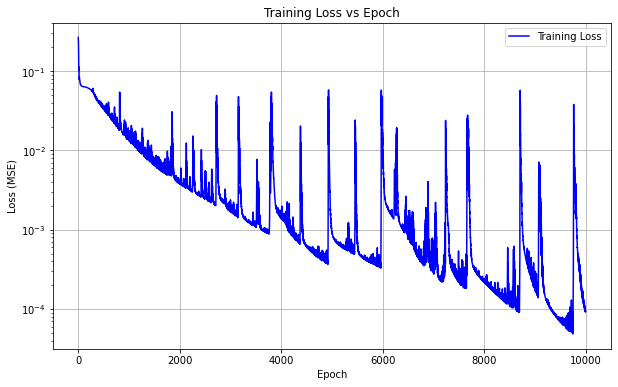


Prediction for daily_step_count=4550, distance_covered=4400:
tempmax: 23.83
tempmin: 0.09
solarradiation: 301.30
uvindex: 9.89


<ipython-input-5-015267813df9>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


In [ ]:
# Main Execution

if __name__ == "__main__":
    
    # Get data
    data = pd.read_csv('step_count_daily_trend_data_merged_incl_weather_daily_users_averaged.csv')
    
    # Prepare the data
    X, y, scaler_X, scaler_y = prepare_data(data)
    
    # Train the model
    epochs = 10000
    trained_model, losses = train_model(X, y)

    # Plot loss vs epoch
    plot_loss_vs_epoch(losses, epochs)
    
    # Get a prediction for some input
    daily_step_count = 4550
    distance_covered = 4400
    prediction = predict_weather(daily_step_count, distance_covered, scaler_X, scaler_y)
    
    print(f"\nPrediction for daily_step_count={daily_step_count}, distance_covered={distance_covered}:")
    for key, value in prediction.items():
        print(f"{key}: {value:.2f}")